In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from catboost import CatBoostRegressor
import xgboost as xgb

from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder
import category_encoders as ce
from category_encoders import TargetEncoder

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [2]:
df_data = pd.read_csv('train.csv')
df_data.head()

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,...,unspecified,NaN,116.0,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575,...,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070,...,partial,"studio, 3, 4, 5, 6 br",56.0,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,Condo,freehold,2023.0,3.0,2.0,958,...,partial,"studio, 1, 2, 3, 4 br",638.0,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,2626000.0
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,732,...,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,https://www.99.co/singapore/condos-apartments/...,1.273959,103.843635,0,anson,downtown core,1764000.0


In [3]:
def preprocess_data(df_data):
    
    # clean data: deal with 'na'(not missing values), etc
    df_data['property_type'] = df_data['property_type'].astype(str).str.lower()
    df_data['tenure'] = df_data['tenure'].astype(str).str.lower()
    df_data['planning_area'] = df_data['planning_area'].str.lower()
    df_data['furnishing'] = df_data['furnishing'].str.lower()
       
    # fill na to unspecified
    df_data['furnishing'].replace({'na': 'unspecified'}, inplace=True)
    # drop outlier
    df_data=df_data.drop(df_data.loc[(df_data['price']>=4985918600.0)].index,0)
    df_data = df_data[df_data["price"] > 0] 
    
    # property type
    df_data["property_type"] = df_data["property_type"].astype(str).replace(r'hdb [0-9] [*a-zA-Z*]', 'hdb', regex=True)
    df_data["property_type"] = df_data["property_type"].replace(("hdbooms"), "hdb")
    df_data["property_type"] = df_data["property_type"].replace(("landed"), "bungalow")
    df_data["property_type"] = df_data["property_type"].replace(("land only"), "bungalow")
    
    # reduce variance
    df_data["size_sqft"] = np.log1p(df_data["size_sqft"])
    df_data["price"] = np.log1p(df_data["price"])
    
    # remove duplicate
    df_data = df_data[~df_data.duplicated(keep='first')]

    df_data = df_data.drop(columns=['address', 'property_details_url', 'title', 'listing_id', 'total_num_units',
                                      'available_unit_types', 'elevation', 'floor_level', 'lat', 'lng', 'subzone'])
    
    return df_data

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df_data_preprocessed = preprocess_data(df_data)


<ipython-input-3-cc2697a8063e>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_data=df_data.drop(df_data.loc[(df_data['price']>=4985918600.0)].index,0)


In [5]:
df_data_preprocessed.head()

,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,planning_area,price
0,866 yishun street 81,hdb,nan,1988.0,3.0,2.0,7.017506,unspecified,yishun,13.150953
1,hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,7.362645,unspecified,serangoon,13.810901
2,meyerhouse,condo,freehold,2022.0,4.0,6.0,8.029759,partial,marine parade,15.953811
3,leedon green,condo,freehold,2023.0,3.0,2.0,6.865891,partial,bukit timah,14.780973
4,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,6.597146,unspecified,downtown core,14.383095


In [6]:
def presplit_encode_data(df_train):

    furnishing_encoder = TargetEncoder()
    furnishing_encoder.fit(df_train['furnishing'], df_train['price'])
    df_train["furnishing"] = furnishing_encoder.transform(df_train["furnishing"])
    
    planning_area_encoder = TargetEncoder()
    planning_area_encoder = planning_area_encoder.fit(df_train['planning_area'], df_train['price'])
    df_train['planning_area'] = planning_area_encoder.transform(df_train['planning_area'])
    
    tenure_encoder = TargetEncoder()
    tenure_encoder.fit(df_train['tenure'], df_train['price'])
    df_train['tenure'] = tenure_encoder.transform(df_train['tenure'])
    
    name_encoder = TargetEncoder()
    name_encoder.fit(df_train['property_name'], df_train['price'])
    df_train['property_name'] = name_encoder.transform(df_train['property_name'])
    
    type_encoder = TargetEncoder()
    type_encoder.fit(df_train['property_type'], df_train['price'])
    df_train['property_type'] = type_encoder.transform(df_train['property_type'])
    
    
    return df_train, furnishing_encoder, planning_area_encoder, tenure_encoder, name_encoder, type_encoder
    

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# %matplotlib inline

# import seaborn as sns
# sns.set()
# cols = df_train.columns
# sns.pairplot(df_train[cols], height = 3.5)
# plt.show();

# from pandas_profiling import ProfileReport
# profile = ProfileReport(df_train, title="Pandas Profiling Report")
# profile.to_file("analyse-1.html")
# median_num = df_train['built_year'].median()
# df_train['built_year'] = df_train['built_year'].fillna(median_num)

In [8]:
def split_data_and_encode(df_data_preprocessed):
    
    df_train = df_data_preprocessed.head(int(len(df_data_preprocessed)*(90/100)))
    df_test = df_data_preprocessed.tail(int(len(df_data_preprocessed)*(10/100)))
    
    df_train, furnishing_encoder, planning_area_encoder, tenure_encoder, name_encoder, type_encoder = presplit_encode_data(df_train)
    
    df_test["furnishing"] = furnishing_encoder.transform(df_test["furnishing"])
    df_test["planning_area"] = planning_area_encoder.transform(df_test["planning_area"])
    df_test["tenure"] = tenure_encoder.transform(df_test["tenure"])
    df_test["property_type"] = type_encoder.transform(df_test["property_type"])
    df_test['property_name'] = name_encoder.transform(df_test['property_name'])
    
    y_train = df_train[['price']]
    X_train = df_train.drop(columns=['price'])
    
    df_test.head()
    
    y_test = df_test[['price']]
    X_test = df_test.drop(columns=['price'])


    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = split_data_and_encode(df_data_preprocessed)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/opt/homebrew/anaconda3/lib/python3.8/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
<ipython-input-6-e984f8f41076>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["furnishing"] = furnishing_encoder.

In [10]:
X_test.head()

,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,planning_area
18230,14.640848,14.677620,15.033322,2024.0,3.0,3.0,7.059618,14.384255,14.722135
18231,14.665557,14.677620,14.072272,2025.0,2.0,2.0,6.597146,14.384255,14.991293
18232,14.486607,14.677620,15.341435,2024.0,3.0,2.0,6.552508,14.384255,14.568563
18233,14.453706,14.677620,14.072272,2025.0,3.0,2.0,6.981935,14.384255,14.715324
18234,14.398303,13.353325,13.762369,2000.0,2.0,2.0,6.520621,14.384255,13.878070


In [11]:
import random

def train_model_predict(X_train, X_test, y_train):
    
    clf1 = xgb.XGBRegressor(n_estimators=473, max_depth=14, tree_method='auto', eval_metric='rmse', eta=0.317)
    clf1 = clf1.fit(X_train, y_train)
    
    y_pred = clf1.predict(X_test)
    
    return y_pred, clf1

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
%%time
y_pred, clf1 = train_model_predict(X_train, X_test, y_train)

CPU times: user 5.57 s, sys: 70.5 ms, total: 5.64 s
Wall time: 5.64 s


In [13]:
# use randomization to look for better parameters

# benmark = 551787495.9392773
# for _ in range(10000):
#     y_pred, y_test, clf1, d, r, g = train_model_predict(X_train, X_test, y_train, y_test)
#     y_pred[y_pred < 0] = 0
#     y_test[y_test < 0] = 0

#     y_test_after = np.expm1(y_test)
#     y_pred_after = np.expm1(y_pred)

#     from sklearn.metrics import mean_squared_error as MSE
    
#     try:
#         rms = np.sqrt(MSE(y_test_after, y_pred_after))
#         if rms < benmark:
#             benmark = rms
#             min_d = d
#             min_r = r
#             min_g = g

#             print(str(rms) + " " +str(min_d) +" "+ str(min_r) + " " +str(min_g))
#     except:
#         print(y_pred)


In [14]:
y_pred[y_pred < 0] = 0
y_test[y_test < 0] = 0

y_test = np.expm1(y_test)
y_pred = np.expm1(y_pred)


rms = mean_squared_error(y_test, y_pred, squared=False)
print(rms)

from sklearn.metrics import mean_squared_error as MSE
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse)) 

2089270.8767644195
RMSE :  2089270.876764


In [15]:
def visualize_result(y_pred, y_test):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.title("prediction", fontsize=20)
    plt.plot(y_pred)
    plt.subplot(122)
    plt.title("true value", fontsize=20)
    plt.plot(y_test)
    plt.show()

/opt/homebrew/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


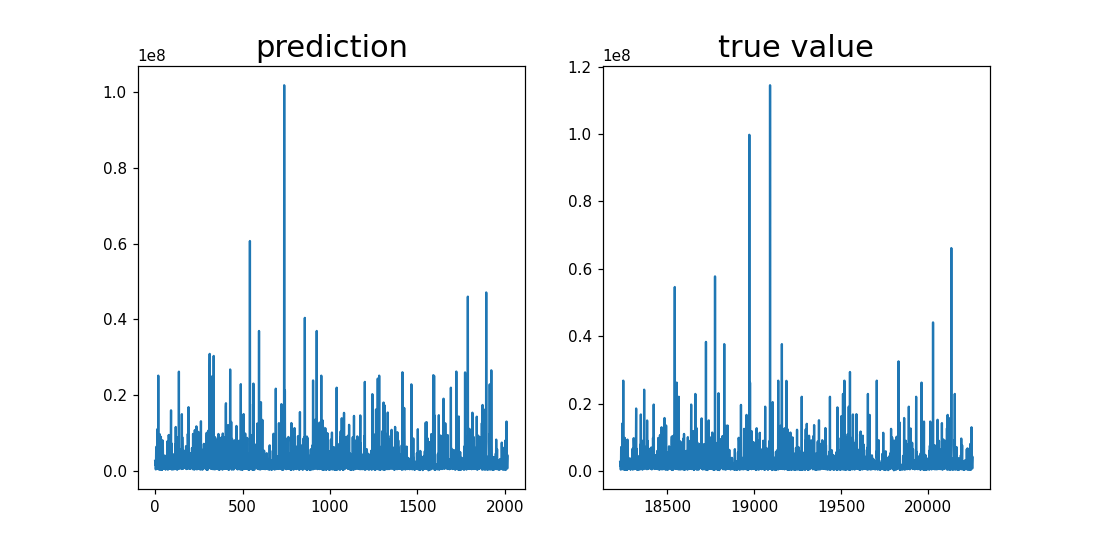

In [16]:
visualize_result(y_pred, y_test)